In [1]:
import utils
from models import VGNN
from sklearn import metrics
import numpy as np
from utils import IC_ICIR_score_calculate, R2_score_calculate

import torch
import random


In [2]:
# load data
print("Loading dataset...")
features, labels, adj_Ind, adj_Loc = utils.load_data()
# features shape: [Months, Firms, Dimension of features]
print("Months: {}, Firms: {}, Dimension of features: {}".format(features.shape[0], features.shape[1], features.shape[2]))

Loading dataset...
Months: 120, Firms: 3050, Dimension of features: 94


In [3]:
# Split data
rnn_length = 12
train_end_time = 12 * 7
val_end_time = 12 * 9
X_train, X_eval, X_test = features[:train_end_time], features[train_end_time - rnn_length + 1:val_end_time], features[val_end_time - rnn_length + 1:]
y_train, y_eval, y_test = labels[:train_end_time], labels[train_end_time - rnn_length + 1:val_end_time], labels[val_end_time - rnn_length + 1:]

In [4]:
# load model
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dropout', type=float, default=0.6, help='Dropout rate (1 - keep probability).')
parser.add_argument('--alpha', type=float, default=0.2, help='Alpha for the leaky_relu.')
parser.add_argument('--hidden', type=int, default=64, help='Number of hidden units.')
parser.add_argument('--hidden_RNN', type=int, default=32, help='Hidden size of RNN.')
parser.add_argument('--hidden_spillover', type=int, default=32, help='Hidden size of spillover embedding.')
parser.add_argument('--nclass', type=int, default=1, help='Number of class.')

args = parser.parse_args([])

model = VGNN(nfeat=features.shape[-1],
             nhid=args.hidden,
             hidden_RNN=args.hidden_RNN,
             hidden_spillover=args.hidden_spillover,
             nclass=args.nclass,
             dropout=args.dropout,
             alpha=args.alpha)

model.load_state_dict(torch.load('{}.pkl'.format(40), map_location='cpu'))

<All keys matched successfully>

In [5]:
# Test result
def compute_test():
    model.eval()
    phase_pred_test = []
    phase_label_test = []
    test_seq = list(range(len(X_test) + 1))[rnn_length:]
    for i in test_seq:
        with torch.no_grad():
            output, _, _ = model(adj_Ind, adj_Loc, X_test[i - rnn_length: i])
        phase_pred_test.extend(output.detach().cpu().numpy().reshape(-1))
        phase_label_test.extend(y_test[i - 1].detach().cpu().numpy())

    mse_test = metrics.mean_squared_error(np.array(phase_label_test), np.array(phase_pred_test))
    r2_test = R2_score_calculate(np.array(phase_label_test), np.array(phase_pred_test))
    rank_ic_test, rank_ic_ir_test = IC_ICIR_score_calculate(phase_label_test, phase_pred_test, len(test_seq))
    print('Test results:',
          'loss_test: {:.4f}'.format(mse_test),
          'R2_test: {:.4f}'.format(r2_test),
          'Rank_IC_test: {:.4f}'.format(rank_ic_test),
          'Rank_ICIR_test: {:.4f}'.format(rank_ic_ir_test))

    return np.array(phase_pred_test), np.array(phase_label_test)


pred_test, labels_test = compute_test()

Test results: loss_test: 0.0645 R2_test: 0.0163 Rank_IC_test: 0.0633 Rank_ICIR_test: 0.6292


In [6]:
pred_test = pred_test.reshape(12, 3050)
labels_test = labels_test.reshape(12, 3050)

In [7]:
# back-testing
def back_testing(pred, label):
    
    # investment budget:$10,000
    capital = 10000
    capital_list = [10000]
    for month in range(pred.shape[0]):
        # top 50
        top_50_index = pred[month].argsort()[-50:]
        # Dividing the investment budget ($10,000) equally into 50 equal parts 
        capital_per = capital / 50
        return_monthly = 0
        for i in top_50_index:
            return_per = (label[month][i] + 1) * capital_per
            return_monthly += return_per
        capital = return_monthly
        capital_list.append(capital)
        
    return capital_list

In [8]:
VGNN_back_testing = back_testing(pred_test, labels_test)

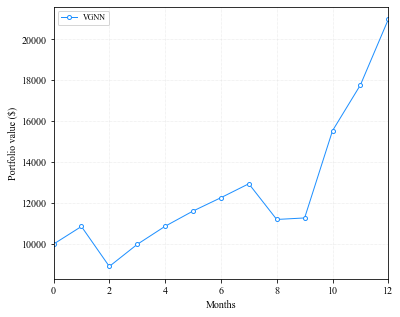

In [9]:
import matplotlib.pyplot as plt

plt.rc('font',family='Times New Roman',size='8')
fig = plt.figure(figsize=(6,5))

plt.plot(VGNN_back_testing, marker = "o",ls='-', mec='dodgerblue', mfc='w', linewidth = 1,markersize=4, label='VGNN', color = 'dodgerblue')
plt.tick_params(labelsize=10)

plt.legend(loc = 'upper left')
plt.xlim(0,12)
plt.xlabel('Months', size = 10)
plt.ylabel('Portfolio value ($)', size = 10)

plt.grid(ls=':', linewidth = 0.5, color = 'lightgray')
# plt.savefig('top_50',dpi = 500)
plt.show()

In [10]:
def sharpe_ratio(protfolio):
    
    r_p_monthly = [(protfolio[i] - protfolio[i-1]) / protfolio[i-1]  for i in range(1, len(protfolio))]
    
    r_f = 0.1
    
    r_ann = ((1 + ((protfolio[-1] - protfolio[0]) / protfolio[0])) ** (12 / len(r_p_monthly))) - 1
    
    SR = (r_ann - r_f) / (np.std(r_p_monthly, ddof = 1) * np.sqrt(12))
    
    return SR, r_ann

In [11]:
SR, r_ann = sharpe_ratio(VGNN_back_testing)
print("The Sharpe ratio is {:.4f}".format(SR)) 
print("The annualized cumulative return of the portfolio is {:.4f}".format(r_ann))

The Sharpe ratio is 2.0177
The annualized cumulative return of the portfolio is 1.0974
